##Many youtube videos were used for the development of this code they are referenced throughout the notebook. The primary video used was <https://www.youtube.com/watch?v=Hrt_gl6r2SI&t=1607s>


In [1]:
!pip install datasets # install the datasets library
!pip install huggingface_hub #install the huggingface_hub library
!pip install huggingface_hub[hf_xet] #install the huggingface_hub library with extra dependencies



These are the libraries i installed to download datasets from hugging face i got the first one from this youtube video <https://www.youtube.com/watch?v=6EwRpVENjKI> and the remaining libraries my IDE instructed me to download them when i got an error trying to download the dataset


In [2]:
import numpy as np # importing numpy for numerical operations
import pandas as pd # importing pandas for data manipulation
import seaborn as sns # importing seaborn for data visualization
import matplotlib.pyplot as plt #importing matplotlib for plotting
import plotly.graph_objs as go #for creating interactive plots
from plotly.offline import init_notebook_mode, iplot #for interactive plotting
from tensorflow.keras.preprocessing.text import one_hot # for one-hot encoding
from tensorflow.keras.preprocessing.sequence import pad_sequences# for padding sequences
from sklearn.model_selection import train_test_split # for splitting the dataset
import tensorflow as tf # importing tensorflow for machine learning
from tensorflow import keras # importing keras for building neural networks
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional # importing layers for the neural network
from tensorflow.keras.preprocessing.text import Tokenizer # for tokenizing text
from sklearn.metrics import classification_report, confusion_matrix # for evaluating the model
import csv # for handling CSV files
from tensorflow.keras.optimizers import Adam # for optimization
from datasets import load_dataset # for loading datasets from Hugging Face
import matplotlib.pyplot as plt # for plotting
from sklearn.utils.class_weight import compute_class_weight # for computing class weights to handle
from tensorflow.keras.layers import Dropout # for regularization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
import string
punc = string.punctuation

In [3]:
spooky_auth = load_dataset("hkadxqq/spooky-author-identification") #loading the spooky author identification dataset from Hugging Face
print(spooky_auth)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



train.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/19579 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'author'],
        num_rows: 19579
    })
})


In [4]:
df = spooky_auth['train'].to_pandas() #converting the dataset to a pandas dataframe

In [5]:
df.to_csv('spooky_author_data.csv', index=False) #saving the dataframe to a CSV file

In [6]:
df.shape #checking the shape of the dataframe

(19579, 3)

In [7]:
df.head() #displaying the first 5 rows of the dataframe

,id,text,author
0,id26305,"This process, however, afforded me no means of...",0
1,id17569,It never once occurred to me that the fumbling...,1
2,id11008,"In his left hand was a gold snuff box, from wh...",0
3,id27763,How lovely is spring As we looked from Windsor...,2
4,id12958,"Finding nothing else, not even gold, the Super...",1


In [8]:
print(df.dtypes.astype(str)) #checking the data types of the columns

id        object
text      object
author     int64
dtype: object


In [9]:
#checking null values
df.isnull().sum()

,0
id,0
text,0
author,0


In [10]:
# Show all duplicated rows
duplicates = df[df.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [id, text, author]
Index: []


In [11]:
#deleting unwanted columns
df.drop(columns = ['id'],
       inplace = True)

In [12]:
df.head()

,text,author
0,"This process, however, afforded me no means of...",0
1,It never once occurred to me that the fumbling...,1
2,"In his left hand was a gold snuff box, from wh...",0
3,How lovely is spring As we looked from Windsor...,2
4,"Finding nothing else, not even gold, the Super...",1


In [13]:
df.value_counts('author') #checking the distribution of the target variable cause i want to inspect class imbalances

,count
author,
0,7900
2,6044
1,5635


##Feature Engineering

In [14]:
#performing feature engineering whereby i am creating new features from the 'comment' column the features include word count, character count, word density, text length, and punctuation count
df['word_count'] = df['text'].apply(lambda x : len(x.split()))
df['char_count'] = df['text'].apply(lambda x : len(x.replace(" ","")))
df['word_density'] = df['word_count'] / (df['char_count'] + 1)
df['text_length'] = df['text'].str.len()
df['punc_count'] = df['text'].apply(lambda x : len([a for a in x if a in punc]))

## This is the code i used for my previous submission last sememster for the sentiment analysis ##

In [15]:
df.head()

,text,author,word_count,char_count,word_density,text_length,punc_count
0,"This process, however, afforded me no means of...",0,41,191,0.213542,231,7
1,It never once occurred to me that the fumbling...,1,14,58,0.237288,71,1
2,"In his left hand was a gold snuff box, from wh...",0,36,165,0.216867,200,5
3,How lovely is spring As we looked from Windsor...,2,34,173,0.195402,206,4
4,"Finding nothing else, not even gold, the Super...",1,27,148,0.181208,174,4


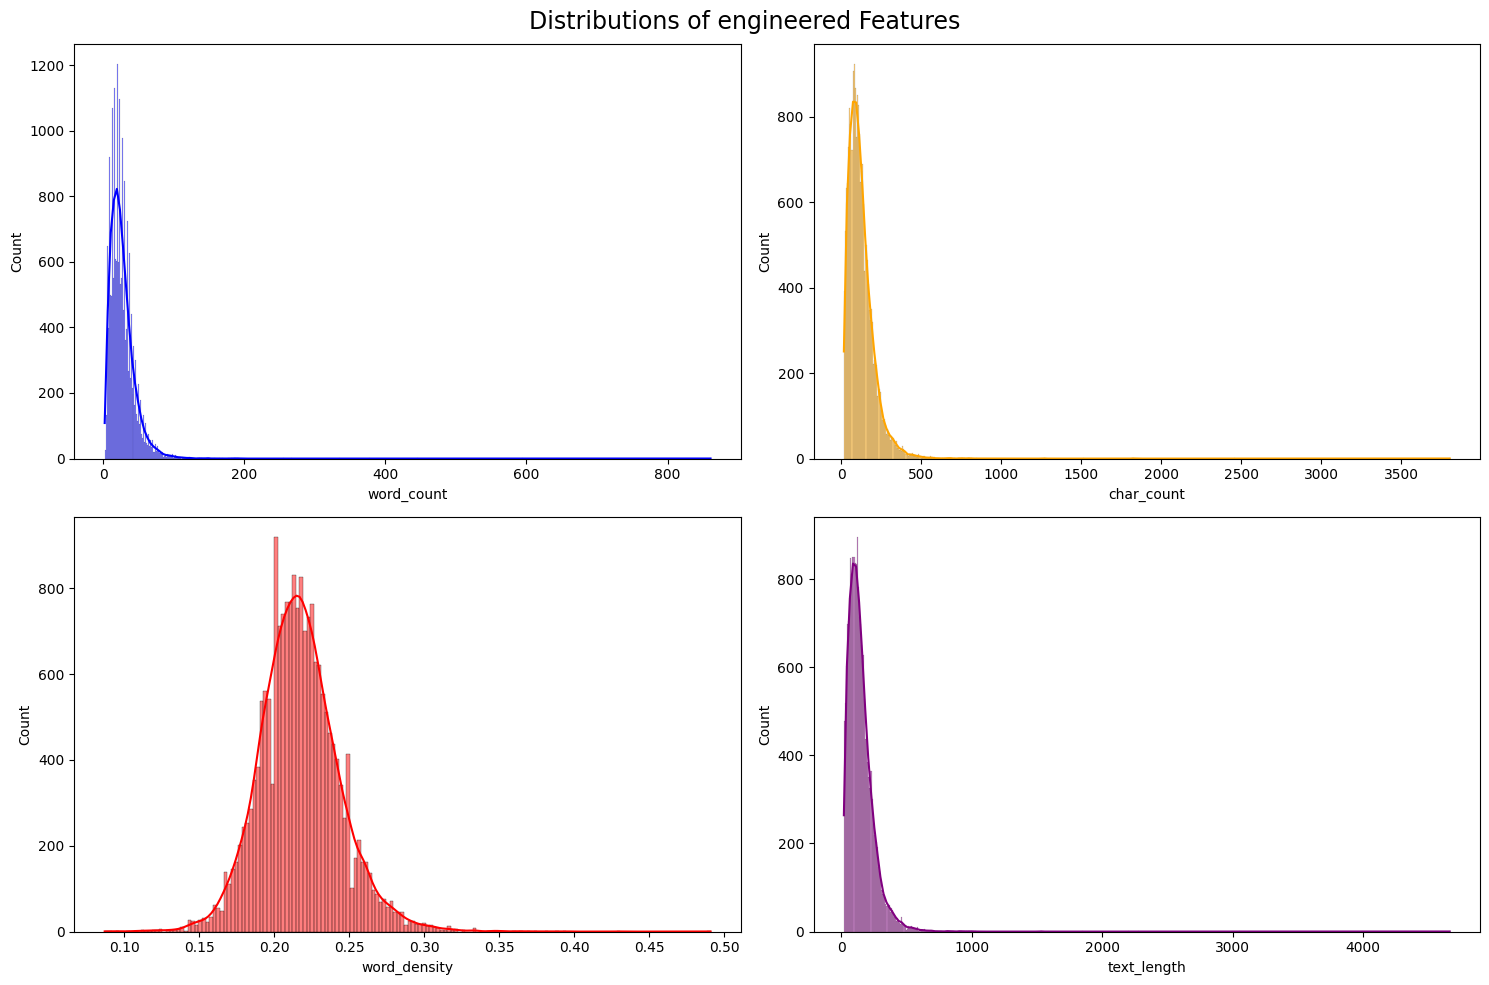

In [16]:
#visualising the distributions of the engineered features using seaborn histogram
#kde is set to true to draw a smooth curve to represent the distribution along with the histogram.
#each histogram is set to a different color for better visual distinction.
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(df["word_count"], kde=True, ax=axes[0, 0], color="blue")
sns.histplot(df["char_count"], kde=True, ax=axes[0, 1], color="orange")
sns.histplot(df["word_density"], kde=True, ax=axes[1, 0], color="red")
sns.histplot(df["text_length"], kde=True, ax=axes[1, 1], color="purple")
fig.suptitle("Distributions of engineered Features", fontsize=17)
plt.tight_layout()

In [17]:
#using the describe function to display the statistics of the feature, including the 95th percentile
f_stats = df[['word_count', 'char_count', 'word_density', 'text_length', 'punc_count']].describe(percentiles=[.25, .5, .75, .95])

# Display the table
display(f_stats)

,word_count,char_count,word_density,text_length,punc_count
count,19579.000000,19579.000000,19579.000000,19579.000000,19579.000000
mean,26.730477,123.326932,0.216942,149.057408,3.759283
std,19.048353,87.952007,0.026834,106.800189,3.009744
min,2.000000,17.000000,0.086957,21.000000,1.000000
25%,15.000000,67.000000,0.200000,81.000000,2.000000
50%,23.000000,106.000000,0.215686,128.000000,3.000000
75%,34.000000,158.000000,0.232444,191.000000,5.000000
95%,58.000000,270.000000,0.261905,326.000000,9.000000
max,861.000000,3803.000000,0.490909,4663.000000,71.000000


code for custom percentiles found at IONOS. (2025, June 16). What is the pandas DataFrame describe() method? IONOS. https://www.ionos.com/digitalguide/websites/web-development/python-pandas-dataframe-describe/

In [18]:
#creating a histogram for each author class to show the distribution of word counts across the different author classes
traces = [] #traces list to hold histogram traces
for author, author_name, color in zip([0, 1, 2], ['0', '1', '2'], ['#AB3260', '#2CA02C', '#1F77B4']): #for each author value, name, and color
  traces.append(
    go.Histogram( #appending a histogram trace to the traces list
      x=df[df['author'] == author]['word_count'], #filtering the dataframe for the current author and getting the word count
      opacity=0.65, #setting the opacity of the histogram bars
      name=author_name, #setting the name of the histogram trace
      marker=dict(color=color) #setting the color of the histogram bars
    )
  )
layout = go.Layout( #defining the layout of the plot
  barmode='overlay', #setting the bar mode to overlay
  title='Word Count Distribution by author', #setting the title of the plot
  xaxis=dict(title='Word Count'), #setting the x-axis title
  yaxis=dict(title='Number of row entries') #setting the y-axis title
)
fig = go.Figure(data=traces, layout=layout) #creating a figure with the traces and layout
iplot(fig) #displaying the plotly histogram

code reused from previous sentiment analysis submission

In [19]:
traces = [] #traces list to hold histogram traces
for author, author_num, color in zip([0, 1, 2], ['0', '1', '2'], ['#AB3260', '#2CA02C', '#1F77B4']):
  traces.append( #appending the histogram trace to the traces list
    go.Histogram( #creating a histogram trace
      x=df[df['author'] == author]['word_density'], #filtering the dataframe for the current author and getting the word density
      opacity=0.65, #setting the opacity of the histogram bars
      name=author_num, #setting the name of the histogram trace
      marker=dict(color=color) #setting the color of the histogram bars
    )
  )
data = traces #data variable to hold the histogram traces
layout = go.Layout( #defining the layout of the plot
  barmode='overlay', #setting the bar mode to overlay
  title='Word Density Distribution by Author', #setting the title of the plot
  xaxis=dict(title='Word Density'), #setting the x-axis title
  yaxis=dict(title='Number of row entries') #setting the y-axis title
)
fig = go.Figure(data=data, layout=layout) #creating a figure with the traces and layout
iplot(fig) #displaying the plotly histogram

code reused from previous sentiment analysis submission

In [20]:
df['processed_text_2'] = df['text'].str.lower() #converting all text to lowercase


Code was obtained from <https://pandas.pydata.org/docs/reference/api/pandas.Series.str.lower.html>

In [21]:
df.head()

,text,author,word_count,char_count,word_density,text_length,punc_count,processed_text_2
0,"This process, however, afforded me no means of...",0,41,191,0.213542,231,7,"this process, however, afforded me no means of..."
1,It never once occurred to me that the fumbling...,1,14,58,0.237288,71,1,it never once occurred to me that the fumbling...
2,"In his left hand was a gold snuff box, from wh...",0,36,165,0.216867,200,5,"in his left hand was a gold snuff box, from wh..."
3,How lovely is spring As we looked from Windsor...,2,34,173,0.195402,206,4,how lovely is spring as we looked from windsor...
4,"Finding nothing else, not even gold, the Super...",1,27,148,0.181208,174,4,"finding nothing else, not even gold, the super..."


In [22]:
#deleting unwanted columns
df.drop(columns = ['text'], inplace = True)

In [23]:
df.head()

,author,word_count,char_count,word_density,text_length,punc_count,processed_text_2
0,0,41,191,0.213542,231,7,"this process, however, afforded me no means of..."
1,1,14,58,0.237288,71,1,it never once occurred to me that the fumbling...
2,0,36,165,0.216867,200,5,"in his left hand was a gold snuff box, from wh..."
3,2,34,173,0.195402,206,4,how lovely is spring as we looked from windsor...
4,1,27,148,0.181208,174,4,"finding nothing else, not even gold, the super..."


In [24]:
#creating a new feature 'words' by splitting the 'processed_text_2' column into words
df['words'] = df['processed_text_2'].apply(lambda x: x.split())

code for splitting the sentence obtained from <https://stackoverflow.com/questions/70396087/using-lambda-function-to-split-a-column-in-a-pandas-dataset>

In [25]:
df.head()

,author,word_count,char_count,word_density,text_length,punc_count,processed_text_2,words
0,0,41,191,0.213542,231,7,"this process, however, afforded me no means of...","[this, process,, however,, afforded, me, no, m..."
1,1,14,58,0.237288,71,1,it never once occurred to me that the fumbling...,"[it, never, once, occurred, to, me, that, the,..."
2,0,36,165,0.216867,200,5,"in his left hand was a gold snuff box, from wh...","[in, his, left, hand, was, a, gold, snuff, box..."
3,2,34,173,0.195402,206,4,how lovely is spring as we looked from windsor...,"[how, lovely, is, spring, as, we, looked, from..."
4,1,27,148,0.181208,174,4,"finding nothing else, not even gold, the super...","[finding, nothing, else,, not, even, gold,, th..."


In [26]:
#flattening the list of lists in the 'words' column into a single list of all words
flat_words = [word for text in df['words'] for word in text]

# Get the amount of unique words by creating a set from the list of all words
unique_words = pd.Series(flat_words).unique()

print(len(unique_words))

44895


code for flattening lists <https://stackoverflow.com/questions/952914/how-do-i-make-a-flat-list-out-of-a-list-of-lists>
code for getting unique words gotten from <https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html>

In [27]:
# Tokenize text data using Tokenizer
vocab_size = 45000 # Defining the vocabulary size which is the maximum number of unique words to keep in the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>") # Initializing the Tokenizer with the specified vocabulary size and out-of-vocabulary token
tokenizer.fit_on_texts(df['processed_text_2']) #fitting the tokenizer on the processed text data

#converting text to sequences
sequences = tokenizer.texts_to_sequences(df['processed_text_2'])

tokenizer - https://nabeelvalley.co.za/docs/data-science-with-python/natural-language-processing-tf/

In [28]:
df['processed_text_2'][0] #displaying this index to see the text before conversion to sequences

'this process, however, afforded me no means of ascertaining the dimensions of my dungeon; as i might make its circuit, and return to the point whence i set out, without being aware of the fact; so perfectly uniform seemed the wall.'

In [29]:
print(sequences[0]) #displaying the first sequence to see if the text has been converted to sequences of integers

[27, 2946, 144, 1373, 23, 37, 295, 3, 7452, 2, 2441, 3, 11, 4557, 17, 7, 80, 180, 49, 4246, 4, 296, 5, 2, 250, 1944, 7, 327, 75, 135, 124, 892, 3, 2, 314, 40, 1439, 4929, 99, 2, 431]


In [30]:
sentence_length = 400 #setting the maximum length of the sequences to 400 as it covers most of the text lengths in the dataset
embedded_text = pad_sequences(sequences, padding = 'pre', maxlen = sentence_length) #padding the sequences to ensure they all have the same length by adding zeros at the beginning of the sequences that are shorter than the maximum length

In [31]:
X = np.array(embedded_text) #assining the padded sequences to X
y = np.array(df['author']) #assigning the target variable author to y

In [32]:
df['author'].value_counts() #checking the distribution of the target variable to see if there are class imbalances as I plan to use class weights during model training

,count
author,
0,7900
2,6044
1,5635


In [33]:
#getting unique classes
classes = np.unique(y)

#computing the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)

#converting class weights to a dictionary format for use in Keras
class_weight_dict = dict(zip(classes, class_weights))
print(class_weight_dict)

{np.int64(0): np.float64(0.8261181434599156), np.int64(1): np.float64(1.1581780538302278), np.int64(2): np.float64(1.079803662033973)}


code for getting class weights obtained at <https://tracyrenee61.medium.com/use-python-to-calculate-class-weights-in-machine-learning-d91545f390d8>

In [34]:
#performing an 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
print(X_train.shape) #printing the shape of the training set
print(X_test.shape) #printing the shape of the test set

(15663, 400)
(3916, 400)


In [36]:
# creating model

#defining the optimizer with a learning rate of 0.0001 and assigning to a variable
opt_1 = Adam(learning_rate=0.0001)

#building the model, it is sequential so layers can be added linearly.it has  an embedding layer, three stacked bidirectional LSTM layers with dropout for regularization, a dense layer with tanh activation, and an output layer with softmax activation for multi-class classification
model = keras.Sequential([
    #embedding layer
    keras.layers.Embedding(input_dim = vocab_size, output_dim=128, input_length = sentence_length),
    #LSTM Layers stacked
    keras.layers.Bidirectional(keras.layers.LSTM(200, return_sequences=True, dropout=0.2)), #first lstm layer with return sequence and dropout
    keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.4)), #second lstm layer with return sequence and dropout
    keras.layers.Bidirectional(keras.layers.LSTM(100, dropout=0.5)), #third lstm layer with dropout
    keras.layers.Dropout(0.4), #dropout layer for regularization
    keras.layers.Dense(128, activation='tanh'), #hidden dense layer with tanh activation
    keras.layers.Dropout(0.5), #dropout layer for regularization
    #output layer
    keras.layers.Dense(3, activation = 'softmax') # 3 neurons for 3 classes
])

model.compile(optimizer = opt_1,
             loss = 'sparse_categorical_crossentropy', #using sparse categorical crossentropy as the loss function since the target variable is numerically encoded and it has more than 2 classes
             metrics = ['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning:

Argument `input_length` is deprecated. Just remove it.



code for learning rate adjustment obtained at<https://www.youtube.com/watch?v=leXkKQU3QsM>
code for building the RNN inspired from <<https://www.youtube.com/watch?v=Hrt_gl6r2SI&t=1607s>>

In [37]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [38]:
#adding callbacks

#overriting the model each time accuracy improves, file name includes epoch and validation accuracy
filepath="best_model.keras"
#using mode=max for accuracy and min for loss
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# this callback stops the training when there is no improvement in the validation loss for 3 consecutive epochs.
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

#CSVlogger logs epoch, accuracy, loss, vall_accuracy, val_loss for later plotting
log_csv = CSVLogger('my_logs.csv', separator=',', append=False)

# Reduce learning rate on plateu
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto', epsilon=0.0001, min_lr=0.0001)
callbacks_list = [checkpoint, early_stop, log_csv, rlrop]

code for the call backs was obtained from this tutorial <https://www.youtube.com/watch?v=vXL64p-Nk6U>

In [39]:
#fitting the model with class weights to handle class imbalances, validation data is the test set and using the callbacks defined above
history1 = model.fit(X_train, y_train, epochs=6, batch_size=32, validation_data=(X_test, y_test) ,class_weight=class_weight_dict, verbose=1, callbacks=callbacks_list)


Epoch 1/6
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.3843 - loss: 1.0859
Epoch 1: val_accuracy improved from -inf to 0.65577, saving model to best_model.keras
490/490 ━━━━━━━━━━━━━━━━━━━━ 69s 116ms/step - accuracy: 0.3844 - loss: 1.0858 - val_accuracy: 0.6558 - val_loss: 0.8042 - learning_rate: 1.0000e-04
Epoch 2/6
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7228 - loss: 0.6718
Epoch 2: val_accuracy improved from 0.65577 to 0.80746, saving model to best_model.keras
490/490 ━━━━━━━━━━━━━━━━━━━━ 58s 118ms/step - accuracy: 0.7228 - loss: 0.6716 - val_accuracy: 0.8075 - val_loss: 0.5018 - learning_rate: 1.0000e-04
Epoch 3/6
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8628 - loss: 0.3553
Epoch 3: val_accuracy improved from 0.80746 to 0.81256, saving model to best_model.keras
490/490 ━━━━━━━━━━━━━━━━━━━━ 57s 116ms/step - accuracy: 0.8628 - loss: 0.3553 - val_accuracy: 0.8126 - val_loss: 0.4856 - learning_rate: 1.0000e-04
Epoch 4/6
490/490 ━━━━━━━━━━━━━

In [40]:
#evaluating the model on the test set to get the loss and accuracy
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy : {accuracy * 100}')

123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.8162 - loss: 0.6206
Model Accuracy : 81.84371590614319


In [41]:
# assigning a variable to the predicted values by getting the index of the maximum value in the prediction array along the last axis
pred = np.argmax(model.predict(X_test), axis = -1)

123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step


In [42]:
#testing the predictions by seeing how well they match the true labels
y_test[:7]

array([0, 2, 2, 0, 1, 2, 0])

In [43]:
pred[:7]

array([0, 2, 2, 0, 0, 2, 1])

In [44]:
#printing the classification report to see precision, recall, f1-score, and support for each class
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1570
           1       0.83      0.80      0.81      1071
           2       0.82      0.80      0.81      1275

    accuracy                           0.82      3916
   macro avg       0.82      0.81      0.82      3916
weighted avg       0.82      0.82      0.82      3916



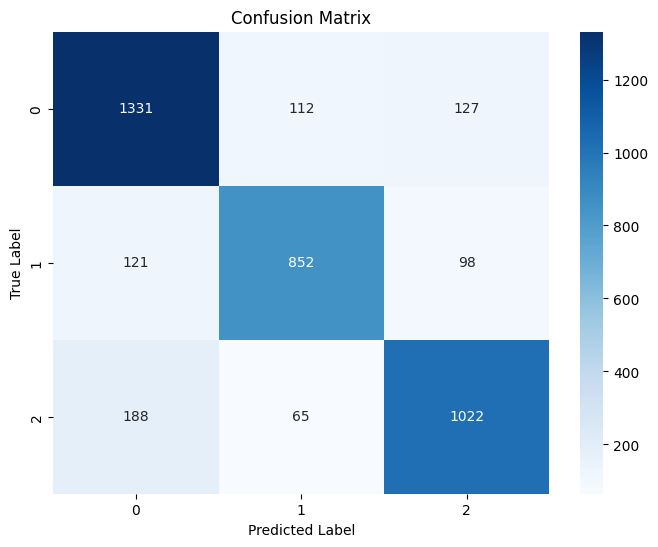

In [45]:
#plotting the confusion matrix to visualize the performance of the model across different classes
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

code for confusion matrix<https://seaborn.pydata.org/generated/seaborn.heatmap.html>